In [ ]:
# include("src/shape.jl") 

build_base_density_2D_general

In [1]:
using SpecialFunctions
using Roots  # For root-finding
using Plots
using LaTeXStrings

In [2]:
function radial_envelope(r, alpha=0.05)
    return exp.(-alpha .* r.^2)
end

radial_envelope (generic function with 2 methods)

In [3]:
"""
Compute the n-th positive root of the Bessel function J_m.
"""
function besseljzero(m, n; tol=1e-8, max_iter=100)
    f(x) = besselj(m, x)  # Define the Bessel function J_m
    roots = []
    x_start = 0.1  # Start slightly above 0 to avoid issues with J_m(0) = 0 for m >= 1
    step_size = 0.5  # Use a smaller step size to avoid skipping roots
    while length(roots) < n
        x_end = x_start + step_size  # Search in smaller intervals
        if f(x_start) * f(x_end) < 0  # Check if the interval brackets a root
            root = find_zero(f, (x_start, x_end), Bisection(), tol=tol)
            push!(roots, root)
            x_start = root + tol  # Move slightly past the root to avoid duplicates
        else
            x_start = x_end  # Expand the search range
        end
    end
    return roots[n]  # Return the n-th root
end

besseljzero

The solution for the oscillations of a circular membrane are given by $e^{im\phi}J_m(\alpha_{mn}/ar)$ where $\alpha_{mn}$ are the $n$-th positive root of $J_m$. Here $m=0,1,\ldots$ and $n=1,2,\ldots$ .

In [4]:
function circular_membrane(phi, r, coeff_dict, a=1.0)
    modulation = ones(size(phi))
    for ((m, n), amp) in coeff_dict
        α_mn = besseljzero(m, n)  # n-th positive root of J_m
        modulation .+= amp .* real.(exp.(im * m .* phi) .* besselj.(m, α_mn ./ a .* r))
        # modulation .+= amp .* cos(m .* phi) .* besselj.(m, α_mn ./ a .* r)
    end
    return modulation  
end

circular_membrane (generic function with 2 methods)

In [5]:
coeff_dict_test = Dict(
    (0, 1) => 0.0, 
    (0, 2) => 0.0, 
    (0, 3) => 0.0,
    (1, 1) => 0.0, 
    (1, 2) => 0.0, 
    (1, 3) => 0.0,
    (2, 1) => 0.0, 
    (2, 2) => 0.0, 
    (2, 3) => 0.0,
    (3, 1) => 1.0,
)

Dict{Tuple{Int64, Int64}, Float64} with 10 entries:
  (1, 2) => 0.0
  (3, 1) => 1.0
  (0, 2) => 0.0
  (1, 1) => 0.0
  (0, 1) => 0.0
  (1, 3) => 0.0
  (2, 2) => 0.0
  (0, 3) => 0.0
  (2, 1) => 0.0
  (2, 3) => 0.0

In [6]:
function density_2D(X, Y, coeff_dict; alpha=0.05, envelope_func=radial_envelope, a=1.0)
    r = sqrt.(X.^2 .+ Y.^2)
    phi = atan.(Y, X)
    phi = ifelse.(phi .< 0, phi .+ 2π, phi)

    env = envelope_func(r, alpha)
    memb = circular_membrane(phi, r, coeff_dict, a)
    density_base = env .* memb
    # density_base = memb
    return density_base
end

density_2D (generic function with 1 method)

In [7]:
function PlotConfiguration()
    L = 1.0
    Nx, Ny = 128, 128  

    x_vals = range(-L, L, length=Nx)
    y_vals = range(-L, L, length=Ny)
    X = repeat(x_vals, 1, Ny) 
    Y = repeat(y_vals', Nx, 1) 

    base_density = density_2D(X, Y, coeff_dict_test; alpha=0.05, envelope_func=radial_envelope, a=1.0)

    heatmap(
        x_vals, y_vals, base_density,
        xlabel=L"x", ylabel=L"y", color=:inferno,
        title="2D Density with Custom Basis Functions",
        aspect_ratio=:equal
    )
end

PlotConfiguration (generic function with 1 method)

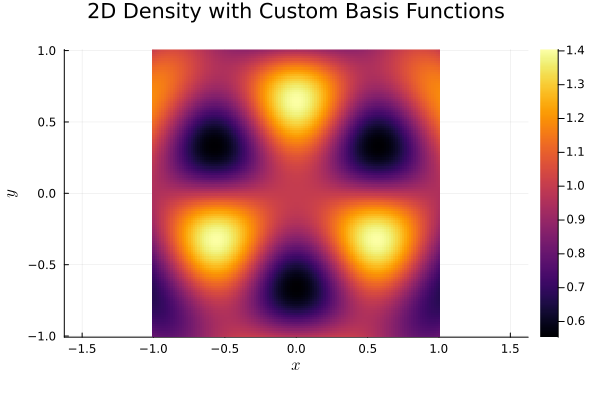

In [8]:
PlotConfiguration()

In [14]:
function PlotMultipleConfigurations()
    L = 1.0
    Nx, Ny = 128, 128  

    x_vals = range(-L, L, length=Nx)
    y_vals = range(-L, L, length=Ny)
    X = repeat(x_vals, 1, Ny) 
    Y = repeat(y_vals', Nx, 1) 

    # Create a 3x3 grid of plots
    plot_grid = []
    for m in 0:3  # Rows correspond to m = 0, 1, 2
        row_plots = []
        for n in 1:4  # Columns correspond to n = 1, 2, 3
            # Define coeff_dict for the specific (m, n) mode
            coeff_dict = Dict((m, n) => 1.0)

            # Compute the density
            base_density = density_2D(X, Y, coeff_dict; alpha=0.05, envelope_func=radial_envelope, a=1.0)

            # Create the heatmap for this mode
            heatmap_plot = heatmap(
                x_vals, y_vals, base_density,
                xlabel=L"x", ylabel=L"y", color=:inferno,
                title=L"m=%$m, n=%$n",
                aspect_ratio=:equal,
                colorbar=false,  # Disable individual colorbars for clarity
                xlims = (-L, L),
                ylims = (-L, L),
            )
            push!(row_plots, heatmap_plot)
        end
        push!(plot_grid, plot(row_plots...; layout=(1, 4)))  # Combine row plots
    end

    # Combine all rows into a single grid
    final_plot = plot(plot_grid...; layout=(4, 1), size=(900, 900))
    display(final_plot)
end

PlotMultipleConfigurations (generic function with 1 method)

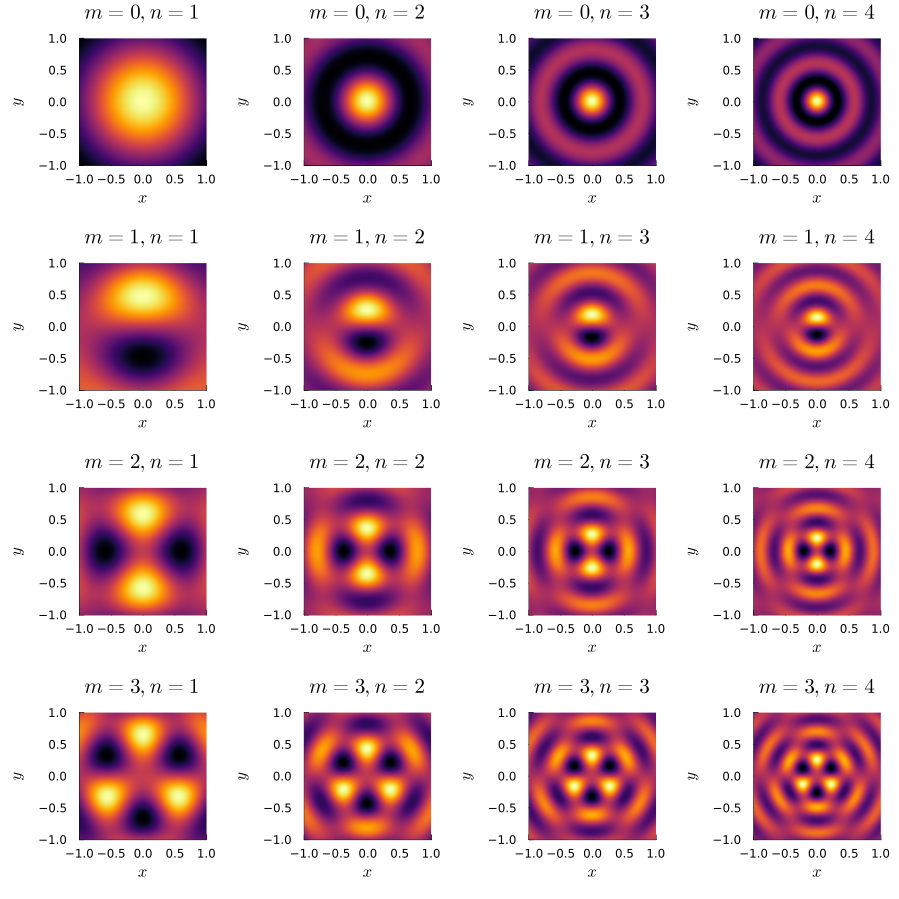

In [15]:
PlotMultipleConfigurations()